In [1]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import scipy
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks


from tqdm.notebook import tqdm
import warnings


from visuals import *
from my_lib import *
from my_lib import NWregression

In [2]:
#warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [12]:
plt.rcParams['text.usetex'] = False

In [13]:
def HankelMatrix(qwe, L):  
    N = qwe.shape[0]
    return scipy.linalg.hankel(qwe[ : N - L + 1], qwe[N - L : N])

def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ((data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

In [14]:
def temp(x,nlags):    
    X_h = HankelMatrix(x, nlags)

    pca = PCA(n_components = 4)
    X_PCA = pca.fit_transform(X_h)

    ##################################################################################################
    ##################################################################################################
    Y_ = X_PCA[::3,:3]

    ax = 0/180 * np.pi
    ay = 90/180 * np.pi
    az = 30/180 * np.pi

    T_X = np.array([[1,0,0],
                    [0,np.cos(ax),-np.sin(ax)],
                    [0,np.sin(ax), np.cos(ax)]])

    T_Y = np.array([[np.cos(ay),-np.sin(ay),0],
                    [np.sin(ay), np.cos(ay),0],
                    [0,0,1]])

    T_Z = np.array([[ np.cos(az),0,np.sin(az)],
                    [ 0,1,0],
                    [-np.sin(az),0,np.cos(az)]])

    Y_ = Y_@T_Y@T_X

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(Y_[:,0],
            Y_[:,1],
            Y_[:,2],
            lw = 1)

    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.view_init(elev=20, azim=135)

    ax.grid(False)
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    #ax.legend()

    # if save_mode:
    #     fig.tight_layout()
    #     fig.savefig('./images_paper/walk_trajectory.eps',
    #                 format='eps',
    #                 dpi=600,
    #                 bbox_inches='tight')

    fig.show()
    fig = go.Figure()
    fig.update_layout(autosize=False, width=700, height=700)
    fig.add_trace(go.Scatter3d(x=Y_[:,0],
                               y=Y_[:,1],
                               z=Y_[:,2],
                               marker=dict(size=0.1,line=dict(width=0.01)),
                               name = 'X_PCA'
                              )
                 )

    fig.layout.template = 'plotly_white'
    fig.show()

In [15]:
def ro_cos(x):
    return (1 - np.cos(x))/2

def ro_chord(x,y):
    x = np.array([np.sin(x), np.cos(x)])
    y = np.array([np.sin(y), np.cos(y)])
    return np.linalg.norm(x-y)

def L1(previous_phi, phi):
    assert isinstance(previous_phi, float)
    loss1 = np.zeros_like(phi)
    loss1 = ro_cos(np.maximum(0, previous_phi - np.array(phi)))
    return loss1

def L2(near_phis, phi):
    """
        near_phis: k x 1
        phi: h x 1
        return: h x 1
    """
    loss2 = np.sum((1 - np.cos(near_phis[:, None] - np.array(phi)[None, :])) / 2, axis=0)
    return loss2

def L3(x, x_neigh, normalization):
    x_array = np.full_like(x_neigh, x)
    loss3 = np.linalg.norm(x_array - x_neigh, axis=1) / normalization.squeeze()
    return loss3

In [16]:
def AutoCorrPhaseIdentifier(x, period, plot_acf = True):
    
    acf_result = acf(x[:], nlags = len(x), fft=True)
    
    if plot_acf:
        plt.plot(acf_result)
        
    acf_indeces_phase = scipy.signal.find_peaks(acf_result, distance = int(period * 0.75))[0]
    
    acf_indeces_phase = np.append(np.array([0]), acf_indeces_phase)
    phase = np.array([])
    for i in range(len(acf_indeces_phase)-1):
        i_start = acf_indeces_phase[i]
        i_end = acf_indeces_phase[i+1]
    
        phase = np.append(phase, np.linspace(0, 2*np.pi, int(i_end - i_start)))
    
    period_end = len(x) - acf_indeces_phase[-1]
    
    phase = np.append(phase, np.linspace(0, 2 * np.pi * period_end/int(i_end - i_start), period_end))
    return phase

In [58]:
def plot_signal_phases(x_acc, phases, freq=500, save_path=None):
    def _scatter_phase(y, name, phase, ax, ax_phase, freq=500):
        # no labels

        # now determine nice limits by hand:
        binwidth = 0.25
        #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        #lim = (int(xymax/binwidth) + 1) * binwidth

        ax_phase.plot(phase, label=name)
        ax_phase.set_xticks(np.arange(len(y))[::freq])
        ax_phase.set_xticklabels(np.round(np.arange(len(y))/freq, 2)[::freq])


    left, width = 0.1, 1.
    bottom, height = 0.1, 0.3
    spacing = 0.005


    rect_plot = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]

    # start with a square Figure
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_axes(rect_histx)
    ax.tick_params(axis="x", labelbottom=False)
    ax.set_ylabel('$s(t)$', size=20)
    # the scatter plot:
    ax.plot(x_acc)
    ax_phasex = fig.add_axes(rect_plot, sharex=ax)
    ax_phasex.set_yticks(np.linspace(0, 2*np.pi, 9))
    ax_phasex.set_yticklabels([r"0", r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",
                              r"$\pi$",r"$5\pi/4$",r"$3\pi/2$",r"$7\pi/4$",
                              r"$2\pi$"])
    ax_phasex.set_xlabel('$t,c$', size=20)
    ax_phasex.set_ylabel('$\phi(t)$', size=20)

    # use the previously defined function
    for name, phase in phases.items():
        _scatter_phase(x_acc, name, phase, ax, ax_phasex, freq=freq)
    ax_phasex.legend(bbox_to_anchor=(1, 1))
    if save_path is not None:
        fig.tight_layout()
        fig.savefig(save_path,
                    format='eps',
                    dpi=600,
                    bbox_inches='tight')
    return fig

In [59]:
def DelayEmbeddingPhaseIdentifier(
    x,
    nlags = 500,
    epsilon = None,
    min_dim = 4,
    l1 = 1.0,
    l2 = 1.0,
    l3 = 1.0,
    update_coef = 1.5,
    make_plots = False,
    return_variance_model = False,
    return_expectation_model = False
):

    """
    TODO: DESCRIPTION
    x - np.array исходный временной ряд
    nlags - int размер окна больше предполагаемого периода
    epsilon - float область близости в фазовом пространстве для значения фаз
    min_dim  - int размерность подпространства
    l1 - float коэфициенты 1 лосс функции
    l2 - float коэфициенты 2 лосс функции
    l3 - float коэфициенты 3 лосс функции
    update_coef - float коэфициент обновления (update_coef*длинна_первого_периода_по_автокор_функции)
    make_plots - bool орисовка промежуточных этапов
    return_variance_model - bool возвращать ли np.array модели дисперсии
    return_expectation_model - bool возвращать ли np.array модели математического ожидания
    """
    warnings.warn("The method is not optimized. Time complexity O(n^3)")

    # Autocorr and finding indeces of first period
    acf_result = acf(x[nlags-1:],
                     nlags = len(x),
                     fft = True)
    if make_plots:
        plt.figure(figsize=(15,5))
        plt.plot(acf_result)

    peaks_indices = find_peaks(acf_result)[0]
    peaks_height = acf_result[peaks_indices]
    i_indices = sorted(range(len(peaks_indices)), key=lambda i: peaks_height[i], reverse = True)[0]

    period_start, period_stop = 0, peaks_indices[i_indices]
    period = period_stop - period_start
    
    # PCA from initial phase space to lower dimention
    X_maxdim = HankelMatrix(x, nlags)
    pca = PCA(n_components = min_dim)
    X = pca.fit_transform(X_maxdim)

    # Making a model in phase space
    metric = lambda x,y: (1 - np.cos((x-y)))/2
    phase = np.linspace(0, 2 * np.pi, period).reshape((period, 1))
    delta_phase = float(phase[1] - phase[0])

    expectation = NWregression(h = delta_phase,
                               metric = metric)
    expectation.fit(phase, X[period_start: period_stop])
    expectation_array = expectation.predict(phase)

    variance_init = 0.25 * max(distance_matrix(expectation_array, expectation_array, p=2).reshape(-1,))
    variance = NWregression(h = delta_phase,
                            metric = metric)
    variance.fit(phase, np.full((len(expectation_array), 1), variance_init))
    variance_array = variance.predict(phase)

    # Area for history point
    if epsilon is None:
        epsilon = 0.5 * variance_init

    # Implementing of phase retrieval algo 
    history_phase = []
    history_x = []
    n_points = len(expectation_array)
    indeces_array = np.arange(n_points)

    model_phases = np.linspace(0, 2 * np.pi, n_points)
    
    # Updating models parametres
    prev_update = 0
    
    for i in tqdm(np.arange(len(X))):
        # Nearest neigh at the beggining of alg
        if len(history_phase) == 0:
            model_indeces = np.argmin(distance_matrix(np.array([X[i]]), expectation_array, p=2))
            current_phi = model_phases[model_indeces]
            history_x.append(X[0])
            history_phase.append(float(current_phi))
            continue

        # Nearest neigh at the approximation function        
        model_indeces = indeces_array[(np.linalg.norm(X[i][None, :] - expectation_array, axis=1) <= variance_array.squeeze())]


        # IF DIST IS TO BIG FOR CURRENT VARIANCE MODEL
        if len(model_indeces) == 0:
            model_indeces = np.argmin(distance_matrix(np.array([X[i]]), expectation_array, p = 2))
            possible_phi = np.array([model_phases[model_indeces]])
            VARIANCE = np.array([variance_array[model_indeces]])
            EXPECT = np.array([expectation_array[model_indeces]])
        else:
            possible_phi = model_phases[model_indeces]
            VARIANCE = variance_array[model_indeces]
            EXPECT = expectation_array[model_indeces]

        # Nearest neigh at the history
        near_from_history = np.array(history_phase)[(np.linalg.norm(X[i][None, :] - np.array(history_x), axis=1) <= epsilon)]
        
        # Choosing phi acording to loss function
        idx_min = np.argmin(l1 * L1(history_phase[-1], possible_phi)
                            + l2 * L2(near_from_history, possible_phi)
                            + l3 * L3(X[i], EXPECT, VARIANCE)
                           )

        current_phi = possible_phi[idx_min]

        # Filling in history
        history_x.append(X[i])
        history_phase.append(float(current_phi))
        
        # Updates models
        if np.abs(history_phase[-1] -  2 * np.pi) < 2*delta_phase and np.abs(i - prev_update) > update_coef * period:
            np_history_x = np.array(history_x)[prev_update:]
            np_history_phase = np.array(history_phase)[prev_update: , None]
            
            expectation = NWregression(h=delta_phase, metric=metric)
            variance = NWregression(h=delta_phase, metric=metric)
    
            expectation.fit(np_history_phase, np_history_x)
            
            expectation_array = expectation.predict(phase)

            variance_current = np.linalg.norm(np_history_x - expectation.predict(np_history_phase), axis=1)[:, None]
            variance.fit(np_history_phase, variance_current)
            
            variance_array = 3 * variance.predict(phase)
            prev_update = i.copy()

    # Preparing results
    result_dict = {}
    result_dict['phase'] = np.array(history_phase)

    if     return_variance_model:
        result_dict['variance'] = variance_array

    if return_expectation_model:
        result_dict['expectation'] = expectation_array
    return result_dict

# Определяем ограничения

<ipython-input-59-8fb7a66e59e1>:29: UserWarning:

The method is not optimized. Time complexity O(n^3)



<ipython-input-58-4b911bf96f14>:44: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


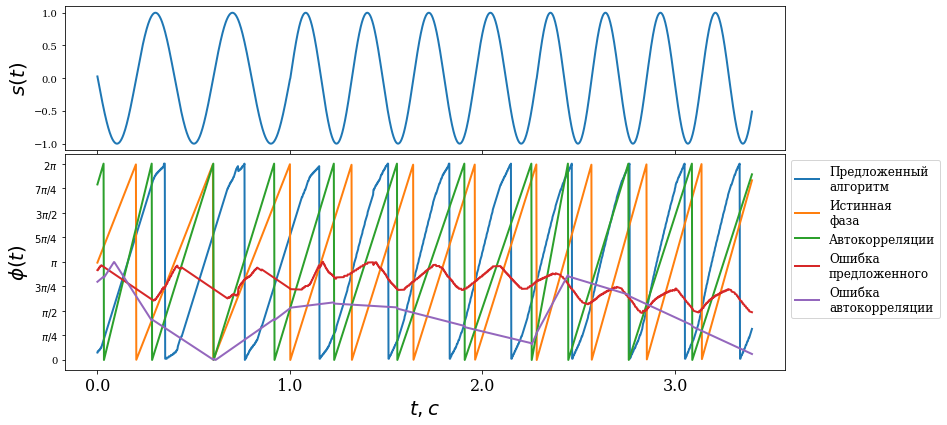

In [65]:
t_mod = np.linspace(0,20,2000)
######################################################
######################################################
# 'freq', 'amp', 'phase'
CHOSEN_NOIZE = 'freq'
######################################################
######################################################

if CHOSEN_NOIZE == 'amp':
    modulation_amp = 1 + np.linspace(0, 1.5, 2000)
    expected = (2 * np.pi  * t_mod)%(2*np.pi)
    x_mod = modulation_amp * np.sin(2 * np.pi * t_mod)
    
elif CHOSEN_NOIZE == 'freq':
    modulation_freq = 0.5*np.ones(800)
    x_mod = np.sin(2 * np.pi * modulation_freq * t_mod[:800])
    expected =  2 * np.pi * modulation_freq * t_mod[:800]
    
    modulation_freq = 1.25 * 0.5 * np.ones(640)
    x_mod = np.concatenate((x_mod, np.sin(2 * np.pi * modulation_freq * t_mod[:640])))
    expected = np.concatenate((
        expected,
        2 * np.pi * modulation_freq * t_mod[:640]))
    
    modulation_freq = 1.4 * 0.5 * np.ones(560)
    x_mod = np.concatenate((x_mod, np.sin(2 * np.pi * modulation_freq * t_mod[:560])))
    expected = np.concatenate((
        expected,
        2 * np.pi * modulation_freq * t_mod[:560]))
    expected = expected%(2*np.pi)
elif CHOSEN_NOIZE == 'phase':
    pass
else:
    pass

fig = go.Figure()
fig.add_scatter(y = x_mod[:], 
                #x = t_mod,
                mode='lines', name='x_acc')
fig.show()

nlags = 300
X_h = HankelMatrix(x_mod, nlags)

pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)
fig_2 = go.Figure()
fig_2.update_layout(autosize=False, width=700, height=700)
fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                             y=X_PCA[:,1],
                             z=X_PCA[:,2],
                             marker=dict(size=0.1,line=dict(width=0.01)),
                             name = 'X_PCA'
                            )
                )
fig_2.layout.template = 'plotly_white'
fig_2.show()

###############################################################
###############################################################
###############################################################

result_dict_mod = DelayEmbeddingPhaseIdentifier(x_mod,
                                                nlags = nlags,
                                                min_dim = 2,
                                                return_variance_model = True,
                                                return_expectation_model = True,
                                                update_coef = 1,
                                                l1 = 1,
                                                l2 = 1,
                                                l3 = 1)

X_h = HankelMatrix(x_mod, nlags)
pca = PCA(n_components = 3)
X_PCA = pca.fit_transform(X_h)

metric = lambda x,y: (1 - np.cos((x-y)))/2
metric_chord = lambda x,y: ((np.sin(x)-np.sin(y))**2+(np.cos(x)-np.cos(y))**2)**.5

if result_dict_mod['expectation'].shape[1]>=3:
    
    
    
    E_expectation = NWregression(h = .1,
                                 metric = metric_chord)
    
    E_expectation.fit(expected[nlags-1:,None], X_PCA[:,:3])
    
    E_expectation_array = E_expectation.predict(np.linspace(0,2*np.pi,800)[:,None])
    
    fig_2 = go.Figure()
    fig_2.update_layout(autosize=False, width=700, height=700)
    fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                                 y=X_PCA[:,1],
                                 z=X_PCA[:,2],
                                 marker=dict(size=0.1,line=dict(width=0.01)),
                                 name = 'X_PCA'
                                )
                    )
    
    fig_2.add_trace(go.Scatter3d(x=E_expectation_array[:,0],
                                 y=E_expectation_array[:,1],
                                 z=E_expectation_array[:,2],
                                 marker=dict(size=0.1,line=dict(width=0.01)),
                                 name = 'E_expectation'
                                )
                    )
    fig_2.add_trace(go.Scatter3d(x=result_dict_mod['expectation'][:,0],
                                 y=result_dict_mod['expectation'][:,1],
                                 z=result_dict_mod['expectation'][:,2],
                                 marker=dict(size=0.1,line=dict(width=0.01)),
                                 name = 'expectation'
                                )
                    )

    fig_2.layout.template = 'plotly_white'
    fig_2.show()
    
else:
    
    E_expectation = NWregression(h = .5,
                                 metric = metric_chord)
    
    E_expectation.fit(expected[nlags-1:,None], X_PCA[:,:3])
    
    E_expectation_array = E_expectation.predict(np.linspace(0,2*np.pi,500)[:,None])
    
    fig = go.Figure()
    fig.add_scatter(x=X_PCA[:,0],
                    y=X_PCA[:,1],
                    mode='lines', name='x_acc')
    
    fig.add_scatter(x=E_expectation_array[:,0],
                    y=E_expectation_array[:,1],
                    mode='lines', name='E_expectation')

    
    fig.add_scatter(y = result_dict_mod['expectation'][:,0], 
                    x = result_dict_mod['expectation'][:,1],
                    mode='lines', name='expectation')


    fig.show()

autocorr_phase = AutoCorrPhaseIdentifier(x = x_mod, period = 3,plot_acf=False)


a = result_dict_mod['phase']
b = expected[nlags-1:]
fig = plot_signal_phases(x_mod[nlags-1:][:], {"Предложенный\nалгоритм": a[:],
                                           "Истинная\nфаза": b[:],
                                           "Автокорреляции": autocorr_phase[nlags-1:],
                                           "Ошибка\nпредложенного": np.arccos((np.cos(a-b)))[:],
                                           "Ошибка\nавтокорреляции": np.arccos((np.cos(autocorr_phase[nlags-1:]-b)))[:]
                                             },
                            save_path = f'./noize_{CHOSEN_NOIZE}.eps')


In [72]:
def plot_signal_phases(x_acc, phases, freq=500, save_path=None):
    def _scatter_phase(y, name, phase, ax, ax_phase, freq=500):
        # no labels

        # now determine nice limits by hand:
        binwidth = 0.25
        #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        #lim = (int(xymax/binwidth) + 1) * binwidth

        ax_phase.plot(phase, label=name)
        ax_phase.set_xticks(np.arange(len(y))[::freq])
        ax_phase.set_xticklabels(np.round(np.arange(len(y))/freq, 2)[::freq])


    left, width = 0.1, 1.
    bottom, height = 0.1, 0.3
    spacing = 0.005


    rect_plot = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]

    # start with a square Figure
    fig = plt.figure(figsize=(7, 10))

    ax = fig.add_axes(rect_histx)
    ax.tick_params(axis="x", labelbottom=False)
    ax.set_ylabel('$s(t)$', size=20)
    # the scatter plot:
    ax.plot(x_acc)
    ax_phasex = fig.add_axes(rect_plot, sharex=ax)
    ax_phasex.set_yticks(np.linspace(0, 2*np.pi, 9))
    ax_phasex.set_yticklabels([r"0", r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",
                              r"$\pi$",r"$5\pi/4$",r"$3\pi/2$",r"$7\pi/4$",
                              r"$2\pi$"])
    ax_phasex.set_xlabel('$t,c$', size=20)
    ax_phasex.set_ylabel('$\phi(t)$', size=20)

    # use the previously defined function
    for name, phase in phases.items():
        _scatter_phase(x_acc, name, phase, ax, ax_phasex, freq=freq)
    ax_phasex.legend(loc = 'upper right')#bbox_to_anchor=(0, 1))
    if save_path is not None:
        fig.tight_layout()
        fig.savefig(save_path,
                    format='eps',
                    dpi=600,
                    bbox_inches='tight')
    return fig

In [73]:
plt.rcParams['legend.fontsize'] = 14

<ipython-input-59-8fb7a66e59e1>:29: UserWarning:

The method is not optimized. Time complexity O(n^3)



<ipython-input-72-93674cb3efda>:44: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


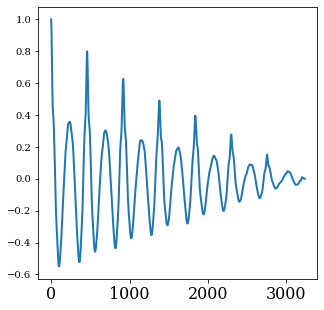

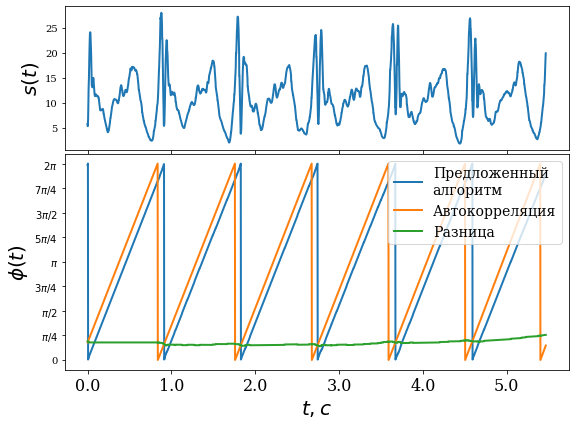

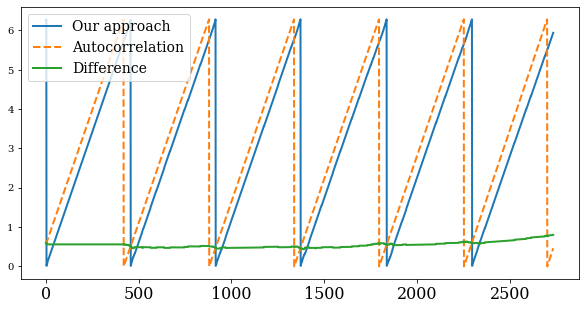

In [74]:
x, t = prepare_time_series('./data/long_walk_100_acc.csv',centred = False)

n_steps = 7
T = 462

dt = T * n_steps
t = t[7174:7174+dt]
x = x[7174:7174+dt]

fig = go.Figure()
fig.add_scatter(y = x[:], mode='lines', name='x_acc')
fig.show()

nlags = 500
result_dict = DelayEmbeddingPhaseIdentifier(x, nlags = nlags,
                                            return_variance_model = True,
                                            return_expectation_model = True)

autocorr_phase = AutoCorrPhaseIdentifier(x = x, period = 500)

a = result_dict['phase']
b = autocorr_phase[nlags-1:]

fig = plot_signal_phases(x[nlags-1:], {"Предложенный\nалгоритм": a,
                                   "Автокорреляция": b,
                                   "Разница": np.arccos(np.cos(a-b))},
                        save_path = f'./noize_walk.eps')

a = result_dict['phase']
b = autocorr_phase[nlags-1:]
plt.figure(figsize=(10,5))
plt.plot(a, label="Our approach")
plt.plot(b,'--', label="Autocorrelation")
plt.plot(np.arccos(np.cos(a-b)), label="Difference")
plt.legend()

<ipython-input-59-8fb7a66e59e1>:29: UserWarning:

The method is not optimized. Time complexity O(n^3)



<ipython-input-72-93674cb3efda>:44: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


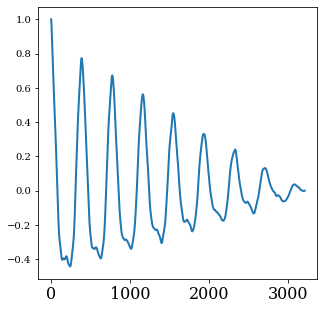

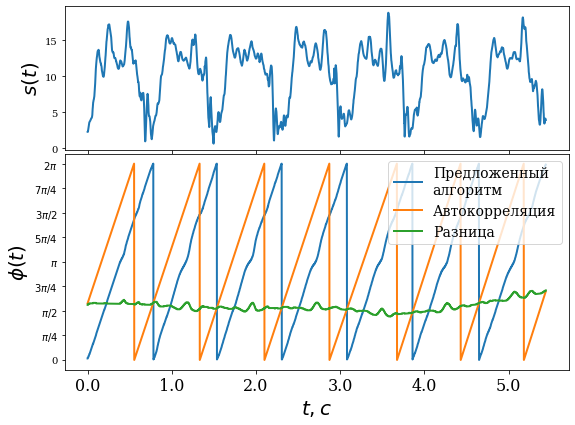

In [75]:
x, t = prepare_time_series('./data/bike _accm.csv',centred = False)

x = x[15_780:19_000]
fig = go.Figure()
fig.add_scatter(y = x[:], mode='lines', name='x_acc')
fig.show()

nlags = 500
result_dict = DelayEmbeddingPhaseIdentifier(x, nlags = nlags,
                                            return_variance_model = True,
                                            return_expectation_model = True,
                                            update_coef = 2,min_dim = 3
                                           )

autocorr_phase = AutoCorrPhaseIdentifier(x = x, period = 500)

a = result_dict['phase']
b = autocorr_phase[nlags-1:]

fig = plot_signal_phases(x[nlags-1:], {"Предложенный\nалгоритм": a,
                                   "Автокорреляция": b,
                                   "Разница": np.arccos(np.cos(a-b))},
                        save_path = f'./noize_bike.eps')

<ipython-input-59-8fb7a66e59e1>:29: UserWarning:

The method is not optimized. Time complexity O(n^3)



<ipython-input-72-93674cb3efda>:44: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


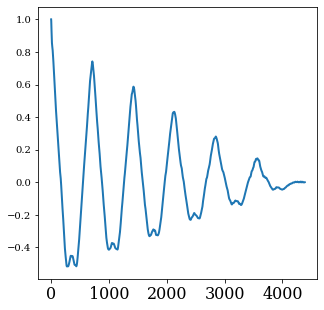

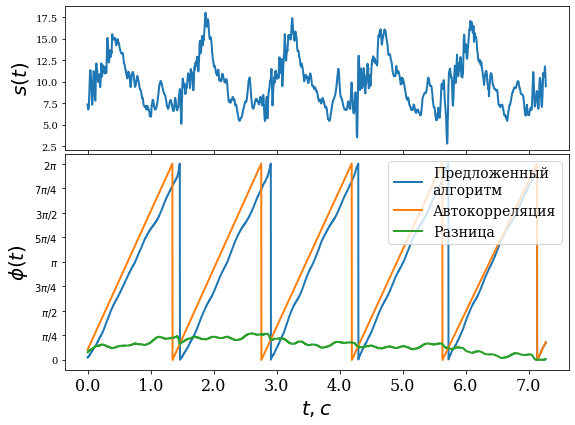

In [76]:
x, t = prepare_time_series('./data/squats_accm.csv',centred = False)

x = x[3670:8056]#14187]
fig = go.Figure()
fig.add_scatter(y = x[:], mode='lines', name='x_acc')
fig.show()

nlags = 750
result_dict = DelayEmbeddingPhaseIdentifier(x, nlags = nlags,
                                            return_variance_model = True,
                                            return_expectation_model = True,
                                           update_coef = 900, min_dim = 2)

autocorr_phase = AutoCorrPhaseIdentifier(x = x, period = 500)

a = result_dict['phase']
b = autocorr_phase[nlags-1:]

fig = plot_signal_phases(x[nlags-1:], {"Предложенный\nалгоритм": a,
                                   "Автокорреляция": b,
                                   "Разница": np.arccos(np.cos(a-b))},
                        save_path = f'./noize_squats.eps')

<ipython-input-59-8fb7a66e59e1>:29: UserWarning:

The method is not optimized. Time complexity O(n^3)



<ipython-input-72-93674cb3efda>:44: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


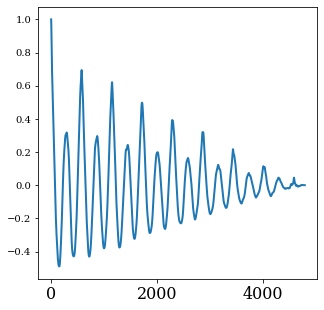

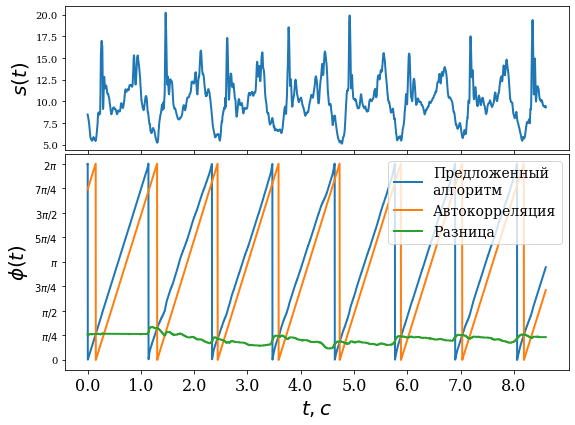

In [77]:
x, t = prepare_time_series('./data/stairs_acc.csv',centred = False)

x = x[2100:6900]
fig = go.Figure()
fig.add_scatter(y = x[:], mode='lines', name='x_acc')
fig.show()

nlags = 500
result_dict = DelayEmbeddingPhaseIdentifier(x, nlags = nlags,
                                            return_variance_model = True,
                                            return_expectation_model = True,
                                            update_coef = 1,min_dim = 4)

autocorr_phase = AutoCorrPhaseIdentifier(x = x, period = 500)

a = result_dict['phase']
b = autocorr_phase[nlags-1:]

fig = plot_signal_phases(x[nlags-1:], {"Предложенный\nалгоритм": a,
                                   "Автокорреляция": b,
                                   "Разница": np.arccos(np.cos(a-b))},
                        save_path = f'./noize_stairs.eps')

In [ ]:
18*10^6 * 70 * 0.87 * 0.125 * 